## 1. Setup and Data Loading

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from lordcapulet.data_structures.databank import DataBank
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.objective import ScalarizedPosteriorTransform

# Import our modular components
from gp_model import create_gp_model, train_gp_model, evaluate_model, print_kernel_diagnostics
from acquisition import compute_total_preference, AnalyticCustomPreference
from optimizer import optimize_acquisition, create_bounds_tensor

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Configuration
DATA_CONFIG = {
    # "json_file": "FeO_scan_data_extractor_redone.json",
    "json_file": "UO2_scan_data_extractor_so_n_converted.json",
    "train_test_ratio": 0.3,
    "include_electron_number": False,
    "include_moment": False,
}

# Physics Mean Configuration
MEAN_CONFIG = {
    "type": "VectorizedPhysicsMean",  # Options: "VectorizedPhysicsMean", None
    # Priors for mean function parameters (also used for initialization)
    "J_prior_mean": 0.2,
    "J_prior_std": 0.1,
    # "J_lin_prior_mean": 0.5,
    # "J_lin_prior_std": 0.02,
    "U_prior_mean": 3.0,
    "U_prior_std": 0.2,
}

# Kernel Configuration
KERNEL_CONFIG = {
    # Local kernels (per atom)
    "local": {
        "matern": {
            "enabled": True,
            "nu": 2.5,
            "outputscale_prior": {"mean": 2.0, "std": 0.2},
        },
    },
    # Non-local kernels (between atom pairs)
    "nonlocal": {
        # "heisenberg": {
        #     "enabled": False,
        #     "outputscale_prior": {"mean": 0.02, "std": 0.002},
        # },
        # "kugel_khomskii": {
        #     "enabled": False,
        #     "outputscale_prior": {"mean": 0.02, "std": 0.002},
        # },
        "residual": {
            "enabled": True,
            "outputscale_prior": {"mean": 0.2, "std": 0.02},
        },
    },
    # Apply spin-flip invariance to all kernels
    "spin_flip_invariant": True,
}

# Optimization Configuration
OPTIMIZATION_CONFIG = {
    "method": "adam",
    "num_restarts": 20,
    "raw_samples": 1048,
    "num_steps": 150,
    "learning_rate": 0.01,
    "use_best_train": False,
    "use_random_train": True,
}

# GP Training Configuration
TRAINING_CONFIG = {
    # Method options:
    # - "fit_gpytorch_mll": Default L-BFGS-B optimizer (recommended)
    # - "sgd": Custom SGD/Adam training loop (DISABLED - issues with Standardize)
    # - "two_stage": Train mean then kernel (DISABLED - issues with Standardize)
    "method": "fit_gpytorch_mll",
    # "method": "sgd",
    # "method": "two_stage",
    
    # SGD configuration (only used if method="sgd")
    "sgd": {
        "epochs": 500,
        "lr": 0.005,
        "optimizer": "adam",  # "sgd" or "adam"
        "print_every": 20,
        # "freeze_kernel": True,  # If True, only train mean parameters, freeze kernel
    },
    
    # Two-stage training configuration (only used if method="two_stage")
    "two_stage": {
        # Stage 1: Train mean function with kernel frozen
        "stage1_epochs": 300,
        "stage1_lr": 0.01,
        "stage1_print_every": 50,
        
        # Stage 2: Train kernel/likelihood with mean frozen
        "stage2_epochs": 500,
        "stage2_lr": 0.002,
        "stage2_print_every": 20,
    },
}

print(f"Running on device: {DEVICE}")


Running on device: cuda


In [22]:
# Load data
databank = DataBank.from_json(
    DATA_CONFIG["json_file"],
    only_converged=True,
    include_electron_number=DATA_CONFIG["include_electron_number"],
    include_moment=DATA_CONFIG["include_moment"],
)

print(f"Loaded {len(databank)} calculations")

# Get available atoms
atoms = databank.atom_ids
print(f"Available atoms: {atoms}")

# get some energies
print(databank.energies.mean())

Loaded 720 calculations
Available atoms: ['1', '2', '3', '4']
-59737.756759766446


In [23]:
# Prepare training data
x_data = databank.to_pytorch(atom_ids=atoms, spins=['up', 'down'], include_energies=False, device=DEVICE)
energies = torch.tensor([rec['energy'] for rec in databank._records], dtype=torch.float32, device=DEVICE)

# Train/test split
num_data = x_data.shape[0]
num_train = int(num_data * DATA_CONFIG["train_test_ratio"])
perm = torch.randperm(num_data)
x_data = x_data[perm]
energies = energies[perm]

x_train = x_data[:num_train]
y_train = energies[:num_train]
x_test = x_data[num_train:]
y_test = energies[num_train:]

print(f"Training data: {x_train.shape[0]} points")
print(f"Test data: {x_test.shape[0]} points")

Training data: 216 points
Test data: 504 points


In [24]:
# Create bounds for optimization
bounds = create_bounds_tensor(databank, atoms, DEVICE)
print(f"Bounds tensor shape: {bounds.shape}")

Bounds tensor shape: torch.Size([2, 224])


## 2. Create and Train GP Model

In [25]:
# Create the GP model
model = create_gp_model(
    train_X=x_train,
    train_Y=y_train.unsqueeze(-1),
    databank=databank,
    atom_ids=atoms,
    mean_config=MEAN_CONFIG,
    kernel_config=KERNEL_CONFIG,
    device=DEVICE
)


/home/carta_a/Documents/Local_calculations/aiida-LordCapulet/lordcapulet/functions/proposal_modes/Bayesian/gp_model.py:62: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


In [26]:
# Train the model
try:
    model = train_gp_model(model, x_train, y_train.unsqueeze(-1), TRAINING_CONFIG)
    print("\nGP model training complete")
except (ValueError, RuntimeError) as e:
    print(f"\nWarning: Training encountered issues: {e}")
    print("This can happen with very small training sets. The model may still be usable.")
    print("Consider increasing train_test_ratio or using a simpler kernel configuration or a smaller learning rate.")


GP model training complete


In [27]:
# Print learned physics parameters
if hasattr(model.mean_module, 'J'):
    print("\n--- Learned Physics Parameters ---")
    print(f"J: {model.mean_module.J.item():.4f}")
    # print(f"J_lin: {model.mean_module.J_lin.item():.4f}")
    print(f"U: {model.mean_module.U.item():.4f}")
    print(f"Constant offset: {model.mean_module.constant.item():.4f} eV")


--- Learned Physics Parameters ---
J: 0.6162
U: 2.3668
Constant offset: -3.3145 eV


In [28]:
# Print kernel diagnostics
print_kernel_diagnostics(model)


KERNEL TYPE                    | VARIANCE (Outputscale)   
LOCAL: Texture (Matern)        | 1.99152                  
LOCAL: Texture (Matern)        | 1.83571                  
LOCAL: Texture (Matern)        | 1.89624                  
LOCAL: Texture (Matern)        | 1.87103                  
NON-LOCAL: Residuals (Mat x Mat) | 0.18838                  
NON-LOCAL: Residuals (Mat x Mat) | 0.18692                  
NON-LOCAL: Residuals (Mat x Mat) | 0.18712                  
NON-LOCAL: Residuals (Mat x Mat) | 0.18972                  
NON-LOCAL: Residuals (Mat x Mat) | 0.19025                  
NON-LOCAL: Residuals (Mat x Mat) | 0.18457                  



## 3. Evaluate Model Performance

In [29]:
# Evaluate on test set
results = evaluate_model(model, x_test, y_test)

print("\n--- Model Performance on Test Set ---")
print(f"R² score: {results['r2']:.4f}")
print(f"RMSE: {results['rmse']:.4f} eV")


--- Model Performance on Test Set ---
R² score: 0.9453
RMSE: 0.1284 eV


In [30]:
# Diagnostic: Check mean function contribution vs kernel
with torch.no_grad():
    # Get mean function predictions
    mean_pred = model.mean_module(x_test)
    
    # Get full model predictions
    full_pred = model(x_test).mean
    
    print("--- Diagnostic: Mean vs Kernel Contributions ---")
    print(f"True energy range: [{y_test.min().item():.2f}, {y_test.max().item():.2f}] eV")
    print(f"Mean function range: [{mean_pred.min().item():.2f}, {mean_pred.max().item():.2f}] eV")
    print(f"Full model range: [{full_pred.min().item():.2f}, {full_pred.max().item():.2f}] eV")
    print(f"\nMean function std: {mean_pred.std().item():.4f} eV")
    print(f"True data std: {y_test.std().item():.4f} eV")
    print(f"Kernel contribution (residual): {(full_pred - mean_pred).std().item():.4f} eV")
    
    # Check if mean function is just a constant
    mean_variation = (mean_pred.max() - mean_pred.min()).item()
    print(f"\nMean function variation: {mean_variation:.4f} eV")
    print(f"Physics contribution (J, U): ~{mean_variation:.4f} eV")
    print(f"Constant offset: {model.mean_module.constant.item():.2f} eV")

--- Diagnostic: Mean vs Kernel Contributions ---
True energy range: [-59738.60, -59735.87] eV
Mean function range: [0.44, 5.62] eV
Full model range: [-1.72, 3.69] eV

Mean function std: 1.0427 eV
True data std: 0.5496 eV
Kernel contribution (residual): 0.1314 eV

Mean function variation: 5.1739 eV
Physics contribution (J, U): ~5.1739 eV
Constant offset: -3.31 eV


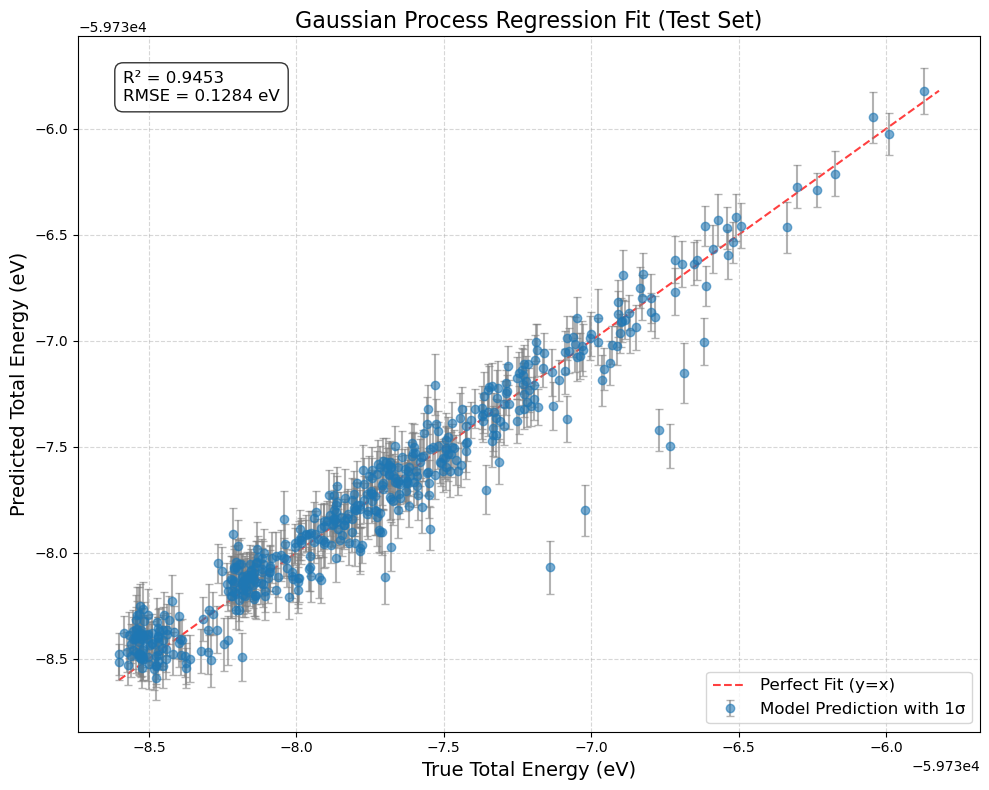

In [31]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 8))

# Plot diagonal line
lims = [
    min(results['y_true'].min(), results['y_pred'].min()),
    max(results['y_true'].max(), results['y_pred'].max()),
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=1, label="Perfect Fit (y=x)")

# Scatter with error bars
plt.errorbar(
    results['y_true'], 
    results['y_pred'], 
    yerr=results['y_std'],
    fmt='o', 
    alpha=0.6, 
    ecolor='gray', 
    capsize=3,
    zorder=2,
    label="Model Prediction with 1σ"
)

plt.xlabel("True Total Energy (eV)", fontsize=14)
plt.ylabel("Predicted Total Energy (eV)", fontsize=14)
plt.title("Gaussian Process Regression Fit (Test Set)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add metrics to plot
text_str = f"R² = {results['r2']:.4f}\nRMSE = {results['rmse']:.4f} eV"
plt.text(
    0.05, 0.95, text_str,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
)

plt.tight_layout()
plt.show()

## 4. Optimize Acquisition Function

In [47]:
# Create base acquisition function (LCB for minimization)
minimize_transform = ScalarizedPosteriorTransform(weights=torch.tensor([-1.0]))
lcb_energy_acqf = UpperConfidenceBound(
    model=model,
    beta=0.2, 
    posterior_transform=minimize_transform,
    maximize=True
)

In [48]:
# Create acquisition function with physics preferences
# Acquisition Function Configuration
ACQUISITION_CONFIG = {
    "type": "LCB",  # Options: "LCB", "EI", "UCB"
    "beta": 0.1,  # LCB/UCB exploration parameter
    # Physics constraints
    "use_preference": True,
    "trace_target": 2.7,

    "trace_sigma": 0.3,
    "eigenvalue_k": 200.0,  # Stiffness for eigenvalue/minor constraint
}





if ACQUISITION_CONFIG["use_preference"]:
    # Create preference function wrapper
    pref_func_wrapper = partial(
        compute_total_preference,
        databank=databank,
        atom_ids=atoms,
        trace_target=ACQUISITION_CONFIG["trace_target"],
        trace_sigma=ACQUISITION_CONFIG["trace_sigma"],
        eig_k=ACQUISITION_CONFIG["eigenvalue_k"]
    )
    
    acqf_final = AnalyticCustomPreference(
        model=model,
        base_acqf=lcb_energy_acqf,
        compute_preference_func=pref_func_wrapper
    )
else:
    acqf_final = lcb_energy_acqf

print("Acquisition function created")

Acquisition function created


In [49]:
# Prepare initial guess (optional)
# Optimization Configuration
OPTIMIZATION_CONFIG = {
    "method": "adam",  # Options: "adam", "lbfgs" (extensible for particle swarm, etc.)
    "num_restarts": 20,
    "raw_samples": 1048,
    "num_steps": 150,
    "learning_rate": 0.01,
    # Initial condition strategy
    "use_best_train": False,  # If True, include random training point
}



initial_guess = None
if OPTIMIZATION_CONFIG["use_best_train"]:
    min_idx = torch.argmin(y_train)
    best_x_so_far = x_train[min_idx]
    initial_guess = best_x_so_far.unsqueeze(0).unsqueeze(0)
else:
    import random
    rand_idx = random.randint(0, x_train.shape[0]-1)
    best_x_so_far = x_train[rand_idx]
    initial_guess = best_x_so_far.unsqueeze(0).unsqueeze(0)

In [51]:
# Optimize acquisition function
print("Optimizing acquisition function...")
candidate, acqf_value = optimize_acquisition(
    acqf=acqf_final,
    bounds=bounds,
    optimization_config=OPTIMIZATION_CONFIG,
    initial_guess=initial_guess
)

print(f"\nOptimization complete")
print(f"Acquisition value: {acqf_value.item():.4f}")

Optimizing acquisition function...


/home/carta_a/Documents/Local_calculations/aiida-LordCapulet/lordcapulet/functions/proposal_modes/Bayesian/optimizer.py:75: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  random_initial_conditions = gen_batch_initial_conditions(



Optimization complete
Acquisition value: 0.0000


## 5. Analyze Candidate

In [55]:
# Get predicted energy for candidate
with torch.no_grad():
    posterior = model.posterior(candidate)
    mean = posterior.mean
    stddev = posterior.variance.sqrt()
    
print(f"Expected Energy: {mean.item():.4f} eV ± {stddev.item():.4f} eV")

Expected Energy: -59736.6875 eV ± 0.0369 eV



Atom ID: 1

Up Matrix:
[[ 0.046  0.    -0.    -0.003 -0.     0.     0.   ]
 [ 0.     0.039 -0.     0.     0.    -0.007 -0.   ]
 [-0.    -0.     0.033 -0.    -0.    -0.     0.001]
 [-0.003  0.    -0.     0.039 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.107 -0.    -0.   ]
 [ 0.    -0.007 -0.    -0.    -0.     0.043  0.   ]
 [ 0.    -0.     0.001 -0.    -0.     0.     0.035]]

Down Matrix:
[[ 0.094 -0.    -0.    -0.03  -0.     0.    -0.   ]
 [-0.     0.053 -0.     0.     0.    -0.013 -0.   ]
 [-0.    -0.     0.987 -0.     0.     0.    -0.01 ]
 [-0.03   0.    -0.     0.058 -0.    -0.    -0.   ]
 [-0.     0.     0.    -0.     0.131 -0.    -0.   ]
 [ 0.    -0.013  0.    -0.    -0.     0.053  0.   ]
 [-0.    -0.    -0.01  -0.    -0.     0.     0.974]]

Trace (Up + Down): 2.692
Eigenvalues Up: [0.033 0.034 0.035 0.038 0.047 0.048 0.107]
Eigenvalues Down: [0.04  0.041 0.066 0.111 0.131 0.969 0.992]


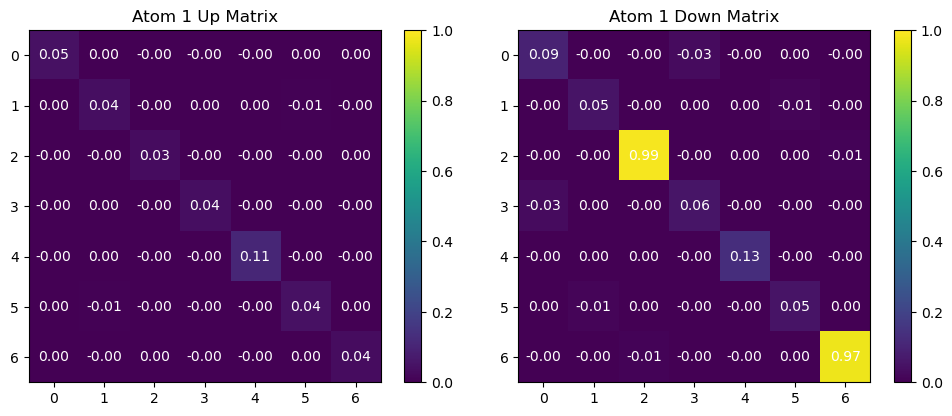


Atom ID: 2

Up Matrix:
[[ 0.06  -0.    -0.    -0.005 -0.     0.    -0.   ]
 [-0.     0.134 -0.     0.     0.    -0.045 -0.   ]
 [-0.    -0.     0.394 -0.    -0.     0.     0.444]
 [-0.005  0.    -0.     0.041 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.139 -0.    -0.   ]
 [ 0.    -0.045  0.    -0.    -0.     0.063  0.   ]
 [-0.    -0.     0.444 -0.    -0.     0.     0.62 ]]

Down Matrix:
[[ 0.068 -0.    -0.    -0.011 -0.     0.    -0.   ]
 [-0.     0.152 -0.     0.     0.    -0.05  -0.   ]
 [-0.    -0.     0.291 -0.    -0.     0.     0.314]
 [-0.011  0.    -0.     0.045 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.135 -0.    -0.   ]
 [ 0.    -0.05   0.    -0.    -0.     0.063  0.   ]
 [-0.    -0.     0.314 -0.    -0.     0.     0.443]]

Trace (Up + Down): 2.648
Eigenvalues Up: [0.04  0.041 0.049 0.061 0.139 0.156 0.965]
Eigenvalues Down: [0.041 0.041 0.044 0.072 0.135 0.174 0.69 ]


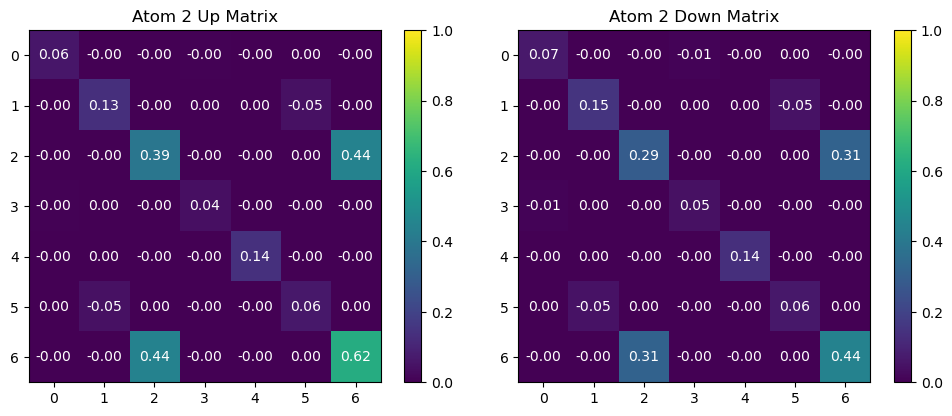


Atom ID: 3

Up Matrix:
[[ 0.049 -0.    -0.    -0.004 -0.     0.     0.   ]
 [-0.     0.046  0.     0.     0.    -0.01  -0.   ]
 [-0.     0.     0.7    0.     0.    -0.    -0.432]
 [-0.004  0.     0.     0.038 -0.    -0.    -0.   ]
 [-0.     0.     0.    -0.     0.115 -0.    -0.   ]
 [ 0.    -0.01  -0.    -0.    -0.     0.043  0.   ]
 [ 0.    -0.    -0.432 -0.    -0.     0.     0.344]]

Down Matrix:
[[ 0.045  0.    -0.     0.002 -0.     0.     0.   ]
 [ 0.     0.628 -0.    -0.     0.     0.452 -0.   ]
 [-0.    -0.     0.048 -0.    -0.    -0.     0.012]
 [ 0.002 -0.    -0.     0.038 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.118  0.    -0.   ]
 [ 0.     0.452 -0.    -0.     0.     0.418 -0.   ]
 [ 0.    -0.     0.012 -0.    -0.    -0.     0.049]]

Trace (Up + Down): 2.679
Eigenvalues Up: [0.034 0.037 0.05  0.055 0.055 0.115 0.989]
Eigenvalues Down: [0.036 0.037 0.046 0.059 0.061 0.118 0.987]


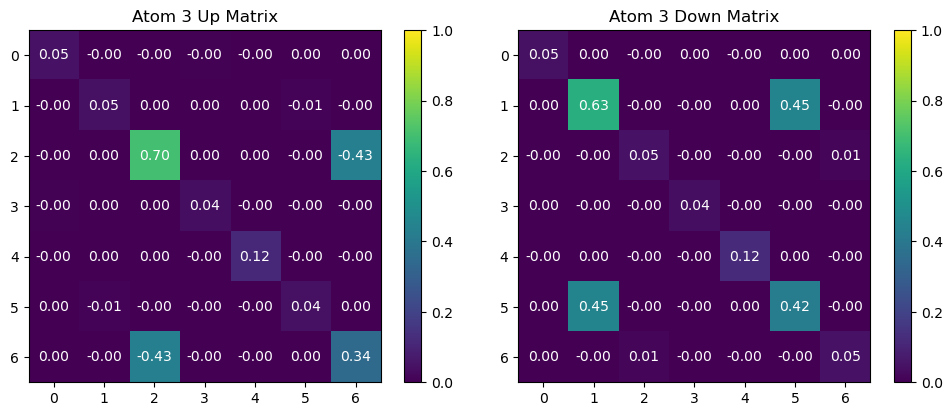


Atom ID: 4

Up Matrix:
[[ 0.06  -0.    -0.    -0.055 -0.     0.     0.   ]
 [-0.     0.044  0.     0.     0.    -0.003 -0.   ]
 [-0.     0.     0.598 -0.     0.    -0.    -0.459]
 [-0.055  0.    -0.     0.988 -0.     0.     0.   ]
 [-0.     0.     0.    -0.     0.128 -0.    -0.   ]
 [ 0.    -0.003 -0.     0.    -0.     0.045  0.   ]
 [ 0.    -0.    -0.459  0.    -0.     0.     0.457]]

Down Matrix:
[[ 0.047  0.    -0.     0.002 -0.     0.     0.   ]
 [ 0.     0.043 -0.     0.     0.    -0.003 -0.   ]
 [-0.    -0.     0.045 -0.    -0.     0.     0.014]
 [ 0.002  0.    -0.     0.03  -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.112 -0.    -0.   ]
 [ 0.    -0.003  0.    -0.    -0.     0.039  0.   ]
 [ 0.    -0.     0.014 -0.    -0.     0.     0.045]]

Trace (Up + Down): 2.681
Eigenvalues Up: [0.041 0.048 0.057 0.063 0.128 0.991 0.992]
Eigenvalues Down: [0.03  0.031 0.037 0.045 0.047 0.059 0.112]


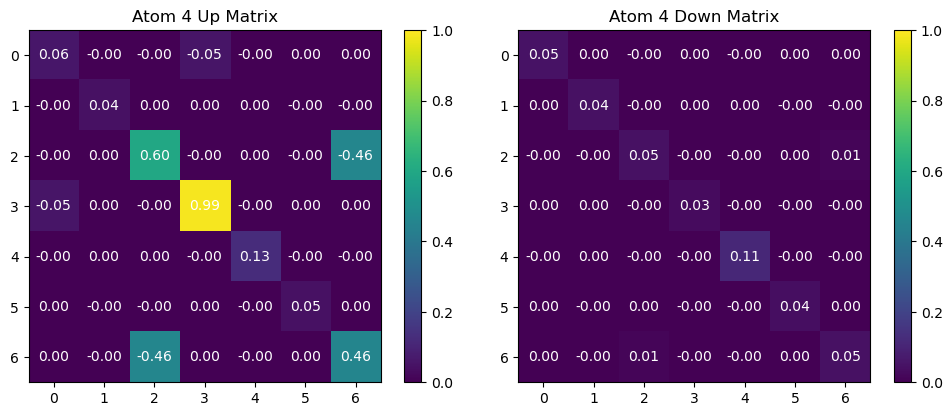

In [56]:
# Unflatten and display occupation matrices
# Detach the candidate from the computation graph before converting
matrices_candidate = databank.from_pytorch(candidate[0].detach().unsqueeze(0), atom_ids=atoms, spins=['up', 'down'])[0]

for atom_id in atoms:
    up_matrix = matrices_candidate.get_occupation_matrix(atom_id, 'up')
    down_matrix = matrices_candidate.get_occupation_matrix(atom_id, 'down')
    
    up_matrix_np = np.array(up_matrix)
    down_matrix_np = np.array(down_matrix)
    
    print(f"\n{'='*60}")
    print(f"Atom ID: {atom_id}")
    print(f"{'='*60}")
    
    print("\nUp Matrix:")
    print(np.round(up_matrix_np, 3))
    
    print("\nDown Matrix:")
    print(np.round(down_matrix_np, 3))
    
    # Compute physical properties
    trace = np.trace(up_matrix_np) + np.trace(down_matrix_np)
    eigvals_up = np.linalg.eigvalsh(up_matrix_np)
    eigvals_down = np.linalg.eigvalsh(down_matrix_np)
    
    print(f"\nTrace (Up + Down): {trace:.3f}")
    print(f"Eigenvalues Up: {np.round(eigvals_up, 3)}")
    print(f"Eigenvalues Down: {np.round(eigvals_down, 3)}")
    
    # Visualize matrices
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Up matrix
    im1 = axs[0].imshow(abs(up_matrix_np), cmap='viridis', vmax=1.0, vmin=0.0)
    axs[0].set_title(f'Atom {atom_id} Up Matrix')
    for i in range(up_matrix_np.shape[0]): 
        for j in range(up_matrix_np.shape[1]):
            axs[0].text(j, i, f"{up_matrix_np[i, j]:.2f}", ha='center', va='center', color='w')
    fig.colorbar(im1, ax=axs[0])
    
    # Down matrix
    im2 = axs[1].imshow(abs(down_matrix_np), cmap='viridis', vmax=1.0, vmin=0.0)
    axs[1].set_title(f'Atom {atom_id} Down Matrix')
    for i in range(down_matrix_np.shape[0]):   
        for j in range(down_matrix_np.shape[1]):
            axs[1].text(j, i, f"{down_matrix_np[i, j]:.2f}", ha='center', va='center', color='w')
    fig.colorbar(im2, ax=axs[1])
    
    plt.tight_layout()
    plt.show()

## Summary

This notebook demonstrates the complete workflow:

1. **Data Loading**: Load occupation matrices from DataBank
2. **Model Creation**: Build GP with physics-based mean and flexible kernel
3. **Training**: Train using simple or two-stage approach
4. **Evaluation**: Assess model performance on test data
5. **Optimization**: Find next candidate using constrained acquisition function
6. **Analysis**: Visualize and validate the proposed candidate

All settings can be controlled through `config.py` for easy experimentation.